In [5]:
%reload_ext autoreload

%autoreload 2

import os

import iris
import matplotlib.pyplot as plt
import metpy
import numpy as np
import xarray as xr

from ml_downscaling_emulator import UKCPDatasetMetadata
from ml_downscaling_emulator.utils import cp_model_rotated_pole, platecarree

# Making new features from existing data

## Precip (pr)

MOOSE data only has lsrain and lssnow (in $kg m^{-2} s^{-1}$ for CPM models. Total precipitation is the sum of these two values.

In [17]:
lssnow_path = f'{os.getenv("DERIVED_DATA")}/moose/london/2.2km-coarsened-27x/rcp85/01/lssnow/day/lssnow_rcp85_land-cpm_london_2.2km-coarsened-27x_01_day_19801201-19811130.nc'
lsrain_path = f'{os.getenv("DERIVED_DATA")}/moose/london/2.2km-coarsened-27x/rcp85/01/lsrain/day/lsrain_rcp85_land-cpm_london_2.2km-coarsened-27x_01_day_19801201-19811130.nc'

lssnow_path = f'../../../../data/moose/uk/2.2km/rcp85/01/lssnow/day/lssnow_rcp85_land-cpm_uk_2.2km_01_day_19801201-19811130.nc'
lsrain_path = f'../../../../data/moose/uk/2.2km/rcp85/01/lsrain/day/lsrain_rcp85_land-cpm_uk_2.2km_01_day_19801201-19811130.nc'

# lssnow_ds = xr.open_dataset(lssnow_path)
# lsrain_ds = xr.open_dataset(lsrain_path)
mvar_ds = xr.open_mfdataset([lsrain_path, lssnow_path]).rename({'stratiform_rainfall_flux': 'lsrain'}).rename({'stratiform_snowfall_flux': 'lssnow'})
# mvar_ds.rename({'stratiform_rainfall_flux': 'lsrain'})
# mvar_ds.rename({'stratiform_rainfall_flux': 'lsrain'})

In [18]:
mvar_ds

<xarray.Dataset>
Dimensions:                     (time: 360, grid_latitude: 654,
                                 grid_longitude: 532, bnds: 2)
Coordinates:
  * time                        (time) object 1980-12-01 12:00:00 ... 1981-11...
  * grid_latitude               (grid_latitude) float32 -5.547 -5.511 ... 8.927
  * grid_longitude              (grid_longitude) float32 353.1 353.1 ... 365.2
    forecast_period             (time) timedelta64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
    forecast_reference_time     object 1979-09-01 00:00:00
    realization                 int32 1100000
Dimensions without coordinates: bnds
Data variables:
    lsrain                      (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 654, 532), meta=np.ndarray>
    rotated_latitude_longitude  int32 -2147483647
    time_bnds                   (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
    grid_latitude_bnds          (grid_latitude, bnds) float32 dask.array<chunksize=(654, 2), meta=np.ndarray>
    grid_longitude_bnds         (grid_longitude, bnds) float32 dask.array<chunksize=(532, 2), meta=np.ndarray>
    forecast_period_bnds        (time, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    lssnow                      (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 654, 532), meta=np.ndarray>
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.6
    Conventions:  CF-1.7

In [19]:
pr_ds = mvar_ds.assign(pr=lambda x: sum(x['lssnow'],x['lsrain']))
pr_ds['pr'] = pr_ds['pr'].assign_attrs(units=mvar_ds['lssnow'].attrs['units'], cell_methods=mvar_ds['lssnow'].attrs['cell_methods'], standard_name='pr', grid_mapping=mvar_ds['lssnow'].attrs['grid_mapping'])
pr_ds = pr_ds.drop_vars(['lssnow', 'lsrain'])
pr_ds

<xarray.Dataset>
Dimensions:                     (time: 360, bnds: 2, grid_latitude: 654,
                                 grid_longitude: 532)
Coordinates:
  * time                        (time) object 1980-12-01 12:00:00 ... 1981-11...
  * grid_latitude               (grid_latitude) float32 -5.547 -5.511 ... 8.927
  * grid_longitude              (grid_longitude) float32 353.1 353.1 ... 365.2
    forecast_period             (time) timedelta64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
    forecast_reference_time     object 1979-09-01 00:00:00
    realization                 int32 1100000
Dimensions without coordinates: bnds
Data variables:
    rotated_latitude_longitude  int32 -2147483647
    time_bnds                   (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
    grid_latitude_bnds          (grid_latitude, bnds) float32 dask.array<chunksize=(654, 2), meta=np.ndarray>
    grid_longitude_bnds         (grid_longitude, bnds) float32 dask.array<chunksize=(532, 2), meta=np.ndarray>
    forecast_period_bnds        (time, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    pr                          (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 654, 532), meta=np.ndarray>
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.6
    Conventions:  CF-1.7

In [20]:
# pr_ds.to_netcdf('pr.nc')
iris.load('pr.nc')[0].coord_system()

RotatedGeogCS(37.5, 177.5, ellipsoid=GeogCS(6371229.0))

In [21]:
target_ds = xr.open_dataset('../../src/ml_downscaling_emulator/utils/moose_uk_pr_guide-grid.nc')
# iris.load('/home/henry/cdt/summer/derived_data/moose/london/2.2km/rcp85/01/pr/day/pr_rcp85_land-cpm_london_2.2km_01_day_19801201-19811130.nc')

In [24]:
mvar_ds.coords.update({'grid_longitude': target_ds.coords['grid_longitude']})

mvar_ds.coords['grid_longitude']

<xarray.DataArray 'grid_longitude' (grid_longitude: 532)>
array([353.07196, 353.10794, 353.14395, ..., 365.09753, 365.13354, 365.16956],
      dtype=float32)
Coordinates:
  * grid_longitude           (grid_longitude) float32 353.1 353.1 ... 365.2
    forecast_reference_time  object ...
    realization              int32 ...
Attributes:
    axis:           X
    bounds:         grid_longitude_bnds
    units:          degrees
    standard_name:  grid_longitude

## Vorticty

Calculated from the x and y wind components

In [1]:
import metpy
import metpy.calc as mpcalc

In [22]:
xwind_path = f'{os.getenv("DERIVED_DATA")}/moose/london/2.2km-coarsened-8x/rcp85/01/xwind/day/xwind_rcp85_land-cpm_london_2.2km-coarsened-8x_01_day_19801201-19811130.nc'
ywind_path = f'{os.getenv("DERIVED_DATA")}/moose/london/2.2km-coarsened-8x/rcp85/01/ywind/day/ywind_rcp85_land-cpm_london_2.2km-coarsened-8x_01_day_19801201-19811130.nc'

winds_ds = xr.open_mfdataset([xwind_path, ywind_path]).sel(pressure=850.0)

In [5]:
winds_ds

<xarray.Dataset>
Dimensions:                     (time: 360, grid_latitude: 63,
                                 grid_longitude: 64, bnds: 2)
Coordinates:
  * time                        (time) object 1980-12-01 12:00:00 ... 1981-11...
    pressure                    float32 850.0
  * grid_latitude               (grid_latitude) float32 -1.57 -1.55 ... -0.33
  * grid_longitude              (grid_longitude) float32 360.9 360.9 ... 362.1
    forecast_period             (time) timedelta64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
    forecast_reference_time     object 1979-09-01 00:00:00
    realization                 int32 1100000
Dimensions without coordinates: bnds
Data variables:
    xwind                       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 63, 64), meta=np.ndarray>
    rotated_latitude_longitude  int32 -2147483647
    time_bnds                   (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
    grid_latitude_bnds          (grid_latitude, bnds) float32 dask.array<chunksize=(63, 2), meta=np.ndarray>
    grid_longitude_bnds         (grid_longitude, bnds) float32 dask.array<chunksize=(64, 2), meta=np.ndarray>
    forecast_period_bnds        (time, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    ywind                       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 63, 64), meta=np.ndarray>
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.6
    Conventions:  CF-1.7

In [65]:
dx, dy = mpcalc.lat_lon_grid_deltas(winds_ds.grid_longitude.values, winds_ds.grid_latitude.values)
dx = dx[None, :]
dy = dy[None, :]
print(dx.shape)
print(dy.shape)

(1, 63, 63)
(1, 62, 64)


In [24]:
mpcalc.vorticity(winds_ds['xwind'], winds_ds['ywind'], dx=dx, dy=dy).isel(time=0)

<xarray.DataArray (grid_latitude: 63, grid_longitude: 64)>
<Quantity([[ 2.16840434e-19 -2.16840434e-19 -2.16840434e-19 ...  6.50521303e-19
   2.26940887e-05  6.80822661e-05]
 [ 2.16840434e-19  0.00000000e+00 -2.16840434e-19 ... -2.16840434e-19
   2.26938730e-05  6.80816189e-05]
 [-4.33680869e-19  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.26936600e-05  6.80809800e-05]
 ...
 [ 6.24444992e-05  6.24444992e-05  6.24444992e-05 ...  5.62976510e-05
   1.01523728e-05 -1.00952668e-04]
 [ 0.00000000e+00  0.00000000e+00  2.16840434e-19 ... -4.33680869e-19
  -4.61451770e-05 -1.38435531e-04]
 [-8.67361738e-19  0.00000000e+00  0.00000000e+00 ...  2.16840434e-19
  -4.61450815e-05 -1.38435244e-04]], '1 / second')>
Coordinates:
    time                     object 1980-12-01 12:00:00
    pressure                 float32 850.0
  * grid_latitude            (grid_latitude) float32 -1.57 -1.55 ... -0.33
  * grid_longitude           (grid_longitude) float32 360.9 360.9 ... 362.1
    forecast_period          timedelta64[ns] dask.array<chunksize=(), meta=np.ndarray>
    forecast_reference_time  object 1979-09-01 00:00:00
    realization              int32 1100000

## Raw wind and rain: the case of different grids

### PP data

In [38]:
xwind_pp_path = f'../../../../data/moose/pp/uk/2.2km/rcp85/01/xwind/day/1981/data/*.pp'
ywind_pp_path = f'../../../../data/moose/pp/uk/2.2km/rcp85/01/ywind/day/1981/data/*.pp'
lsrain_pp_path = f'../../../../data/moose/pp/uk/2.2km/rcp85/01/lsrain/day/1981/data/*.pp'

xwind_cube = iris.load(xwind_pp_path)
ywind_cube = iris.load(ywind_pp_path)
lsrain_cube = iris.load(lsrain_pp_path)

In [36]:
xwind_cube

[<iris 'Cube' of x_wind / (m s-1) (time: 360; pressure: 17; grid_latitude: 655; grid_longitude: 532)>]

In [39]:
ywind_cube

[<iris 'Cube' of y_wind / (m s-1) (time: 360; pressure: 17; grid_latitude: 655; grid_longitude: 532)>]

In [40]:
lsrain_cube

[<iris 'Cube' of stratiform_rainfall_flux / (kg m-2 s-1) (time: 360; grid_latitude: 654; grid_longitude: 532)>]

### NC data

In [45]:
xwind_nc_path = f'../../../../data/moose/uk/2.2km/rcp85/01/xwind/day/xwind_rcp85_land-cpm_uk_2.2km_01_day_19801201-19811130.nc'
ywind_nc_path = f'../../../../data/moose/uk/2.2km/rcp85/01/ywind/day/ywind_rcp85_land-cpm_uk_2.2km_01_day_19801201-19811130.nc'
lsrain_nc_path = f'../../../../data/moose/uk/2.2km/rcp85/01/lsrain/day/lsrain_rcp85_land-cpm_uk_2.2km_01_day_19801201-19811130.nc'

xwind_ds = xr.open_dataset(xwind_nc_path)
ywind_ds = xr.open_dataset(ywind_nc_path)
lsrain_ds = xr.open_dataset(lsrain_nc_path)

In [50]:
xwind_ds

<xarray.Dataset>
Dimensions:                     (time: 360, grid_latitude: 655,
                                 grid_longitude: 532, bnds: 2)
Coordinates:
  * time                        (time) object 1980-12-01 12:00:00 ... 1981-11...
    pressure                    float32 850.0
  * grid_latitude               (grid_latitude) float32 -5.565 -5.529 ... 8.945
  * grid_longitude              (grid_longitude) float32 353.1 353.1 ... 365.2
    forecast_period             (time) timedelta64[ns] 450 days 12:00:00 ... ...
    forecast_reference_time     object 1979-09-01 00:00:00
    realization                 int32 1100000
Dimensions without coordinates: bnds
Data variables:
    x_wind                      (time, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  int32 -2147483647
    time_bnds                   (time, bnds) object 1980-12-01 00:00:00 ... 1...
    grid_latitude_bnds          (grid_latitude, bnds) float32 -5.583 ... 1.07...
    grid_longitude_bnds         (grid_longitude, bnds) float32 353.1 ... 365.2
    forecast_period_bnds        (time, bnds) float64 1.08e+04 ... 1.944e+04
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.6
    Conventions:  CF-1.7

In [49]:
ywind_ds

<xarray.Dataset>
Dimensions:                     (time: 360, grid_latitude: 655,
                                 grid_longitude: 532, bnds: 2)
Coordinates:
  * time                        (time) object 1980-12-01 12:00:00 ... 1981-11...
    pressure                    float32 850.0
  * grid_latitude               (grid_latitude) float32 -5.565 -5.529 ... 8.945
  * grid_longitude              (grid_longitude) float32 353.1 353.1 ... 365.2
    forecast_period             (time) timedelta64[ns] 450 days 12:00:00 ... ...
    forecast_reference_time     object 1979-09-01 00:00:00
    realization                 int32 1100000
Dimensions without coordinates: bnds
Data variables:
    y_wind                      (time, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  int32 -2147483647
    time_bnds                   (time, bnds) object 1980-12-01 00:00:00 ... 1...
    grid_latitude_bnds          (grid_latitude, bnds) float32 -5.583 ... 1.07...
    grid_longitude_bnds         (grid_longitude, bnds) float32 353.1 ... 365.2
    forecast_period_bnds        (time, bnds) float64 1.08e+04 ... 1.944e+04
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.6
    Conventions:  CF-1.7

In [48]:
lsrain_ds

<xarray.Dataset>
Dimensions:                     (time: 360, grid_latitude: 654,
                                 grid_longitude: 532, bnds: 2)
Coordinates:
  * time                        (time) object 1980-12-01 12:00:00 ... 1981-11...
  * grid_latitude               (grid_latitude) float32 -5.547 -5.511 ... 8.927
  * grid_longitude              (grid_longitude) float32 353.1 353.1 ... 365.2
    forecast_period             (time) timedelta64[ns] ...
    forecast_reference_time     object ...
    realization                 int32 ...
Dimensions without coordinates: bnds
Data variables:
    stratiform_rainfall_flux    (time, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  int32 ...
    time_bnds                   (time, bnds) object ...
    grid_latitude_bnds          (grid_latitude, bnds) float32 ...
    grid_longitude_bnds         (grid_longitude, bnds) float32 ...
    forecast_period_bnds        (time, bnds) float64 ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.6
    Conventions:  CF-1.7

In [52]:
ds = xr.combine_by_coords([xwind_ds, ywind_ds], compat='no_conflicts', combine_attrs="drop_conflicts", coords="all", join="inner", data_vars="all").sel({'pressure': 850.0})
ds

<xarray.Dataset>
Dimensions:                     (time: 360, grid_latitude: 655,
                                 grid_longitude: 532, bnds: 2)
Coordinates:
  * time                        (time) object 1980-12-01 12:00:00 ... 1981-11...
    pressure                    float32 850.0
  * grid_latitude               (grid_latitude) float32 -5.565 -5.529 ... 8.945
  * grid_longitude              (grid_longitude) float32 353.1 353.1 ... 365.2
    forecast_period             (time) timedelta64[ns] 450 days 12:00:00 ... ...
    forecast_reference_time     object 1979-09-01 00:00:00
    realization                 int32 1100000
Dimensions without coordinates: bnds
Data variables:
    x_wind                      (time, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  int32 -2147483647
    time_bnds                   (time, bnds) object 1980-12-01 00:00:00 ... 1...
    grid_latitude_bnds          (grid_latitude, bnds) float32 -5.583 ... 1.07...
    grid_longitude_bnds         (grid_longitude, bnds) float32 353.1 ... 365.2
    forecast_period_bnds        (time, bnds) float64 1.08e+04 ... 1.944e+04
    y_wind                      (time, grid_latitude, grid_longitude) float32 ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.6
    Conventions:  CF-1.7

In [63]:
dx, dy =  mpcalc.lat_lon_grid_deltas(xwind_ds.grid_longitude.values, xwind_ds.grid_latitude.values)
print(dx.shape)
print(dy.shape)

(655, 531)
(654, 532)


In [75]:
dx, dy =  mpcalc.lat_lon_grid_deltas(ds.grid_longitude.values, ds.grid_latitude.values)
print(dx.shape)
print(dy.shape)

(655, 531)
(654, 532)


In [69]:
dy.shape

(654, 532)

In [70]:
np.all(xwind_ds.grid_longitude.values == ywind_ds.grid_longitude.values)

True

In [71]:
np.all(xwind_ds.grid_latitude.values == ywind_ds.grid_latitude.values)

True

In [72]:
mpcalc.vorticity(ds.isel(time=10)['x_wind'], ds.isel(time=10)['y_wind'], dx=dx, dy=dy)

Magnitude,[[-2.454832484694502e-06 -6.127540272928261e-06 -7.690698291426068e-06 ... 4.1512147469076235e-05 4.132050176767837e-05 4.2948367825583695e-05] [-1.4179797813416474e-06 -4.602927067827705e-06 -5.739822154070566e-06 ... 3.339527312119664e-05 3.1039650973968156e-05 3.279224510542838e-05] [-1.0479261507742414e-07 -2.8928880743182925e-06 -3.7249715593998603e-06 ... 2.808192017516762e-05 2.6338914373858846e-05 3.0355001840017643e-05] ... [-1.871320115966823e-05 -3.630294908801396e-05 -4.500260398563622e-05 ... 0.0 0.0 0.0] [-1.569962772719079e-05 -3.3475743465868134e-05 -4.235836066568786e-05 ... 0.0 0.0 0.0] [-1.0464141255748885e-05 -2.8427042475974714e-05 -3.7186062358003865e-05 ... -4.9223821214337634e-05 0.0 0.0]]
Units,1/second


In [80]:
regridder = iris.analysis.Nearest().regridder(ds['x_wind'].to_iris(), xwind_cube[0])
xr.DataArray.from_iris(regridder(ds['x_wind'].to_iris()))

ValueError: The rectilinear grid coordinates of the given cube and target grid must either both have coordinate systems or both have no coordinate system but with matching coordinate metadata.

In [79]:
ds['x_wind'].to_iris()

<iris 'Cube' of x_wind / (m s-1) (time: 360; grid_latitude: 655; grid_longitude: 532)>

In [93]:
coarsened_ds = ds.coarsen(grid_latitude=32, grid_longitude=32, boundary="trim").mean()

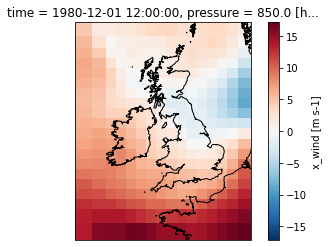

In [99]:
ax = plt.axes(projection=cp_model_rotated_pole)
coarsened_ds.isel(time=0)['x_wind'].plot(ax=ax)
ax.coastlines()

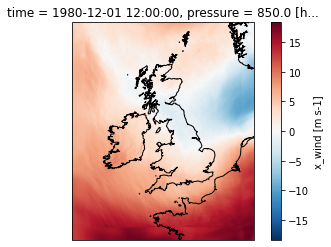

In [90]:
ax = plt.axes(projection=cp_model_rotated_pole)
ds.isel(time=0)['x_wind'].plot(ax=ax)
ax.coastlines()

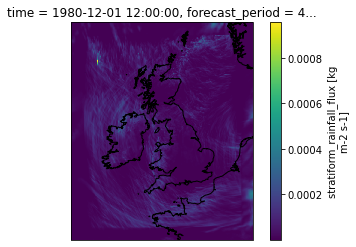

In [97]:
ax = plt.axes(projection=cp_model_rotated_pole)
lsrain_ds.isel(time=0)['stratiform_rainfall_flux'].plot(ax=ax)
ax.coastlines()

In [95]:
xwind_cube[0].coordinate_system

AttributeError: 'Cube' object has no attribute 'coordinate_system'

In [100]:
regridder = iris.analysis.Nearest().regridder(coarsened_ds['x_wind'].to_iris(), ds['x_wind'].to_iris())

<xarray.DataArray 'x_wind' (time: 360, grid_latitude: 655, grid_longitude: 532)>
[125445600 values with dtype=float32]
Coordinates:
  * time                     (time) object 1980-12-01 12:00:00 ... 1981-11-30...
  * grid_latitude            (grid_latitude) float32 -5.565 -5.529 ... 8.945
  * grid_longitude           (grid_longitude) float32 353.1 353.1 ... 365.2
    forecast_reference_time  object ...
    pressure                 float64 ...
    realization              int64 ...
    forecast_period          (time) timedelta64[ns] ...
Attributes:
    standard_name:    x_wind
    units:            m s-1
    um_stash_source:  m01s30i201
    cell_methods:     time: mean (interval: 1 hour)

In [103]:
regridded_coarsened_da = xr.DataArray.from_iris(regridder(coarsened_ds['x_wind'].to_iris()))

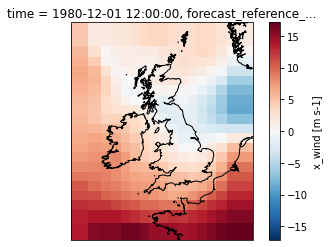

In [104]:
ax = plt.axes(projection=cp_model_rotated_pole)
regridded_coarsened_da.isel(time=0).plot(ax=ax)
ax.coastlines()

In [105]:
regridded_coarsened_da

<xarray.DataArray 'x_wind' (time: 360, grid_latitude: 655, grid_longitude: 532)>
[125445600 values with dtype=float32]
Coordinates:
  * time                     (time) object 1980-12-01 12:00:00 ... 1981-11-30...
  * grid_latitude            (grid_latitude) float32 -5.565 -5.529 ... 8.945
  * grid_longitude           (grid_longitude) float32 353.1 353.1 ... 365.2
    forecast_reference_time  object ...
    pressure                 float64 ...
    realization              int64 ...
    forecast_period          (time) timedelta64[ns] ...
Attributes:
    standard_name:    x_wind
    units:            m s-1
    um_stash_source:  m01s30i201
    cell_methods:     time: mean (interval: 1 hour)

In [106]:
coarsened_ds

<xarray.Dataset>
Dimensions:                     (time: 360, grid_latitude: 20,
                                 grid_longitude: 16, bnds: 2)
Coordinates:
  * time                        (time) object 1980-12-01 12:00:00 ... 1981-11...
    pressure                    float32 850.0
  * grid_latitude               (grid_latitude) float32 -5.007 -3.949 ... 7.852
  * grid_longitude              (grid_longitude) float32 353.6 354.7 ... 363.9
    forecast_period             (time) timedelta64[ns] 450 days 12:00:00 ... ...
    forecast_reference_time     object 1979-09-01 00:00:00
    realization                 int32 1100000
Dimensions without coordinates: bnds
Data variables:
    x_wind                      (time, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  int32 -2147483647
    time_bnds                   (time, bnds) object 1980-12-01 00:00:00 ... 1...
    grid_latitude_bnds          (grid_latitude, bnds) float32 -5.025 ... 7.869
    grid_longitude_bnds         (grid_longitude, bnds) float32 353.6 ... 363.9
    forecast_period_bnds        (time, bnds) float64 1.08e+04 ... 1.944e+04
    y_wind                      (time, grid_latitude, grid_longitude) float32 ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.6
    Conventions:  CF-1.7

In [107]:
ds.isel(time=slice(10))

<xarray.Dataset>
Dimensions:                     (time: 10, grid_latitude: 655,
                                 grid_longitude: 532, bnds: 2)
Coordinates:
  * time                        (time) object 1980-12-01 12:00:00 ... 1980-12...
    pressure                    float32 850.0
  * grid_latitude               (grid_latitude) float32 -5.565 -5.529 ... 8.945
  * grid_longitude              (grid_longitude) float32 353.1 353.1 ... 365.2
    forecast_period             (time) timedelta64[ns] 450 days 12:00:00 ... ...
    forecast_reference_time     object 1979-09-01 00:00:00
    realization                 int32 1100000
Dimensions without coordinates: bnds
Data variables:
    x_wind                      (time, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  int32 -2147483647
    time_bnds                   (time, bnds) object 1980-12-01 00:00:00 ... 1...
    grid_latitude_bnds          (grid_latitude, bnds) float32 -5.583 ... 1.07...
    grid_longitude_bnds         (grid_longitude, bnds) float32 353.1 ... 365.2
    forecast_period_bnds        (time, bnds) float64 1.08e+04 ... 1.104e+04
    y_wind                      (time, grid_latitude, grid_longitude) float32 ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.6
    Conventions:  CF-1.7

## Example vorticity

In [109]:
vds = xr.open_dataset('/home/henry/cdt/summer/derived_data/moose/london/2.2km-coarsened-8x/rcp85/01/vorticity850/day/vorticity850_rcp85_land-cpm_london_2.2km-coarsened-8x_01_day_19801201-19811130.nc')
vds

<xarray.Dataset>
Dimensions:                     (time: 10, grid_latitude: 64,
                                 grid_longitude: 64, bnds: 2)
Coordinates:
  * time                        (time) object 1980-12-01 12:00:00 ... 1980-12...
    pressure                    float32 ...
  * grid_latitude               (grid_latitude) float32 -1.59 -1.57 ... -0.33
  * grid_longitude              (grid_longitude) float32 360.9 360.9 ... 362.1
    forecast_period             (time) timedelta64[ns] ...
    forecast_reference_time     object ...
    realization                 int32 ...
Dimensions without coordinates: bnds
Data variables:
    xwind                       (time, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  int32 ...
    time_bnds                   (time, bnds) object ...
    grid_latitude_bnds          (grid_latitude, bnds) float32 ...
    grid_longitude_bnds         (grid_longitude, bnds) float32 ...
    forecast_period_bnds        (time, bnds) float64 ...
    ywind                       (time, grid_latitude, grid_longitude) float32 ...
    vorticity850                (time, grid_latitude, grid_longitude) float64 ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.6
    Conventions:  CF-1.7

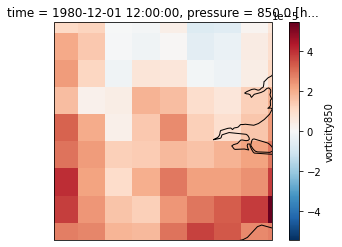

In [110]:
ax = plt.axes(projection=cp_model_rotated_pole)
vds.isel(time=0)['vorticity850'].plot(ax=ax)
ax.coastlines()

In [2]:
vds = xr.open_dataset('/home/henry/cdt/summer/derived_data/moose/london/2.2km-coarsened-16x/rcp85/01/vorticity850/day/vorticity850_rcp85_land-cpm_london_2.2km-coarsened-16x_01_day_19801201-19811130.nc')
vds

<xarray.Dataset>
Dimensions:                  (time: 360, grid_latitude: 64, grid_longitude: 64,
                              bnds: 2)
Coordinates:
    pressure                 float32 ...
    forecast_period          (time) timedelta64[ns] ...
    forecast_reference_time  object ...
    realization              int32 ...
  * time                     (time) object 1980-12-01 12:00:00 ... 1981-11-30...
  * grid_latitude            (grid_latitude) float32 -1.58 -1.56 ... -0.32
  * grid_longitude           (grid_longitude) float32 360.9 360.9 ... 362.1
Dimensions without coordinates: bnds
Data variables:
    vorticity850             (time, grid_latitude, grid_longitude) float64 ...
    grid_latitude_bnds       (grid_latitude, bnds) float32 ...
    grid_longitude_bnds      (grid_longitude, bnds) float32 ...
    time_bnds                (time, bnds) object ...
    forecast_period_bnds     (time, bnds) float64 ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.6
    Conventions:  CF-1.7

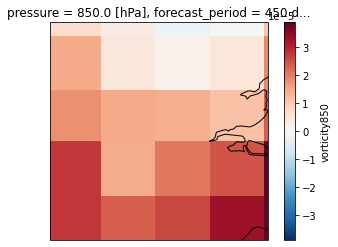

In [26]:
ax = plt.axes(projection=cp_model_rotated_pole)
vds.isel(time=0)['vorticity850'].plot(ax=ax)
ax.coastlines()